In [34]:
import matplotlib
import numpy
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

g = torch.Generator().manual_seed(42)


# Andrej Karpathy Lecture Notes
## Makemore: Lecture 1 

In [35]:
words = open("names.txt","r").read().splitlines() # Download Dataset

b = {} # bigram counts statistics

for w in words:          
    chs = ["<S>"] + list(w) + ["<S>"]

    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1,ch2)
        b[bigram] = b.get(bigram,0) + 1

In [36]:
chars = sorted(list(set("".join(words))))             # Unique, sorted list of characters
stoi  = {ch: 1 + idx for idx, ch in enumerate(chars)} # Dictionary: character to index (starting from 1)
stoi["."] = 0                                         # Assign 0 to special token '.'
itos  = {i: ch for ch, i in stoi.items()}             # Inverse dictionary: index to character


### Exact Method character generation

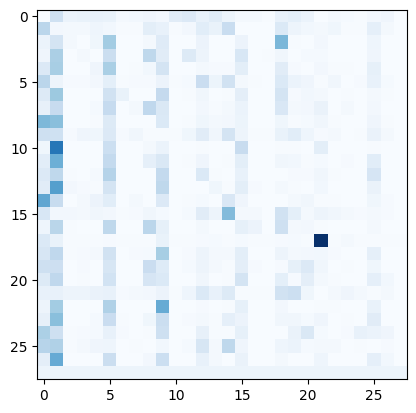

In [37]:
N = torch.zeros((28,28), dtype = torch.int32) # 28x28 matrix for bigram counts

for w in words:
    chs =  ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] += 1

# Probability matrix P
P = (N+1).float()
P /=  P.sum(1, keepdims = True)

plt.imshow(P, cmap = 'Blues')


In [38]:
# Generate 10 words
for i in range(5): 
    ix = 0   # index current character
    out = [] # word vector

    while True:
        p = P[ix]                                                                            # probability vector for the next character
        ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item() # index generated for next character 
        out.append(itos[ix])                                                                 # append next character to the word vector
        if ix == 0:
            break
    print("".join(out))

ya.
syahavilin.
dleekahmangonya.
tryahe.
chen.


In [39]:
# Calculate the negative log likelihood (NLL) of the dataset: llhood = 1/N * sum(log(P(w_i|w_{i-1})))
log_likelihood = 0
n = 0
for w in words:
    chs =  ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        N[ix1,ix2] += 1
        logprob = torch.log(prob)
        log_likelihood += logprob
        n +=1 

nll = -log_likelihood
print(f"Loss is {nll/n}")

KeyboardInterrupt: 

### Training Method

In [ ]:
# Create training set bigrams (x,y)
xs, ys = [], []

for w in words:
    chs =  ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)        
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Randomly initialize the 27 neuron's weight
W = torch.randn((27,27), requires_grad= True)

# training loop
for i in range(100):

    # forward pass
    xenc = F.one_hot(xs, num_classes = 27).float()
    logits = xenc @ W # log-counts
    counts = logits.exp() # equivalent N
    probs = counts / counts.sum(1, keepdims = True)
    loss = - probs[torch.arange(logits.shape[0]),ys].log().mean() + 0.01 * (W**2).mean()

    # backward pass
    W.grad = None
    loss.backward()
    W.data += -3 * W.grad

In [ ]:
for i in range(5): # Generate 5 words
    ix = 0
    out = []

    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes = 27).float()
        logits = xenc @ W # log-counts
        counts = logits.exp() # equivalent N
        probs = counts / counts.sum(1, keepdims = True)
        ix = torch.multinomial(probs, num_samples = 1 , replacement = True, generator = g).item()

        out.append(itos[ix])
        if ix == 0:
            break
    print("".join(out))

ena.
dlppmjiae.
a.
keles.
ls.


## Makemore: Part 2 MLP

In [ ]:
block_size = 3 # context length

def build_dataset(words: str) -> tuple[torch.Tensor, torch.Tensor]:

    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])       # 10%

In [ ]:
class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1D:

    def __init__(self, dim, eps= 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters trained with Backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)
        # Buffers (trained with a running "momentum" update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self,x):

        # Calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True)                # Batch mean
            xvar = x.var(0, keepdim = True, unbiased = True) # Batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return(self.out)
    
    def parameters(self):
        return([self.gamma,self.beta])
    

class Tanh():
    def __call__(self,x):
        self.out = torch.tanh(x)
        return(self.out)

    def parameters(self):
        return []

In [ ]:
# MLP revisted
n_embd = 10
n_hidden = 100 
vocab_size = len(itos)

C = torch.randn((vocab_size,n_embd), generator = g)
layers = [
    Linear(n_embd * block_size,n_hidden),BatchNorm1D(n_hidden),Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden),Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden,vocab_size), BatchNorm1D(vocab_size),
]

with torch.no_grad():
    # Last layer: make less confident
    layers[-1].gamma *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 1.0 # 5.3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"There is a total of {sum(p.nelement() for p in parameters)} parameters")

for p in parameters:
    p.requires_grad = True # Allow gradients to be calculated

There is a total of 47551 parameters


In [ ]:
max_steps = 10000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # mini batch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb]                     # embed the characters into vectors
    x = emb.view(emb.shape[0] ,-1)  # concatenate the vectors
    for layer in layers:            # apply the layers
        x = layer(x)
    loss = F.cross_entropy(x,Yb)    # cross entropy loss

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # track stats
    if i %  10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  50000: 3.3014
  10000/  50000: 1.9547
  20000/  50000: 2.3088
  30000/  50000: 2.2768
  40000/  50000: 1.9139


layer 2 (      Tanh): mean +0.53, std 0.51, saturated: 15.88%
layer 5 (      Tanh): mean +0.55, std 0.51, saturated: 15.62%
layer 8 (      Tanh): mean +0.54, std 0.52, saturated: 14.84%
layer 11 (      Tanh): mean +0.56, std 0.52, saturated: 14.75%
layer 14 (      Tanh): mean +0.55, std 0.54, saturated: 13.69%


Text(0.5, 1.0, 'activation distribution')

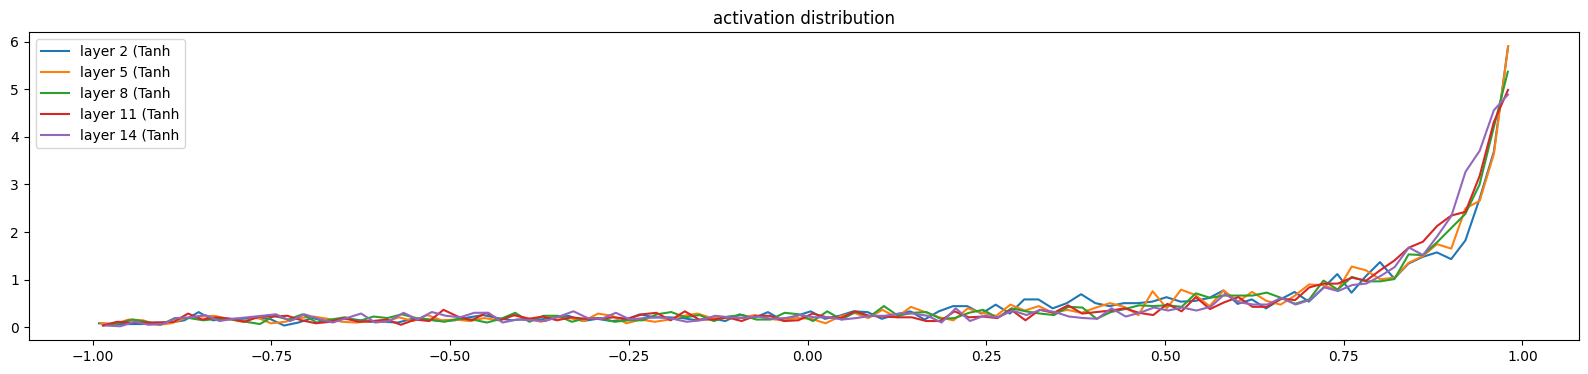

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.634277e-03
layer 5 (      Tanh): mean -0.000000, std 4.269531e-03
layer 8 (      Tanh): mean +0.000000, std 3.999441e-03
layer 11 (      Tanh): mean -0.000000, std 4.083084e-03
layer 14 (      Tanh): mean +0.000000, std 4.376271e-03


Text(0.5, 1.0, 'gradient distribution')

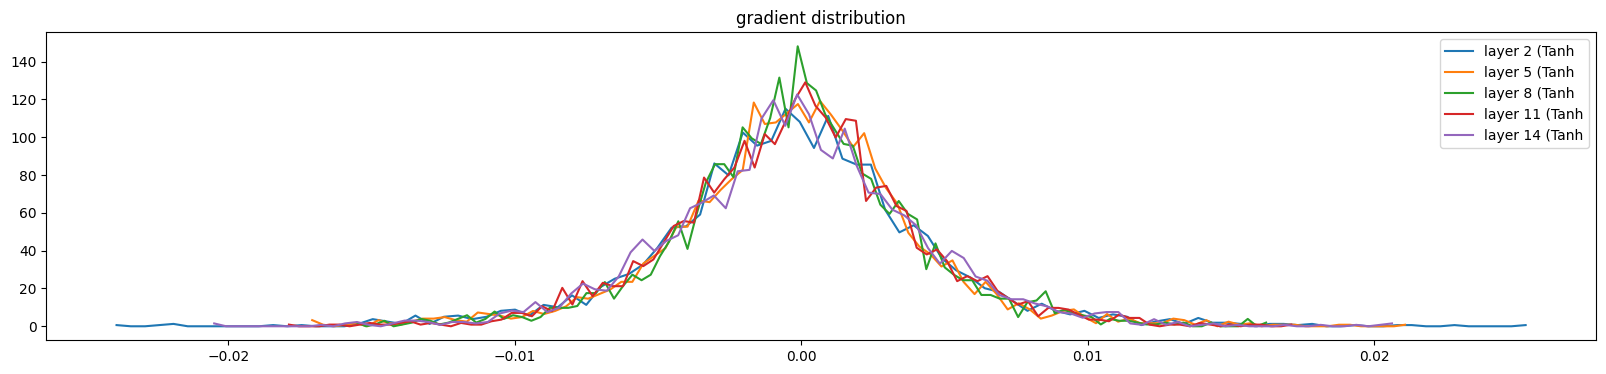

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

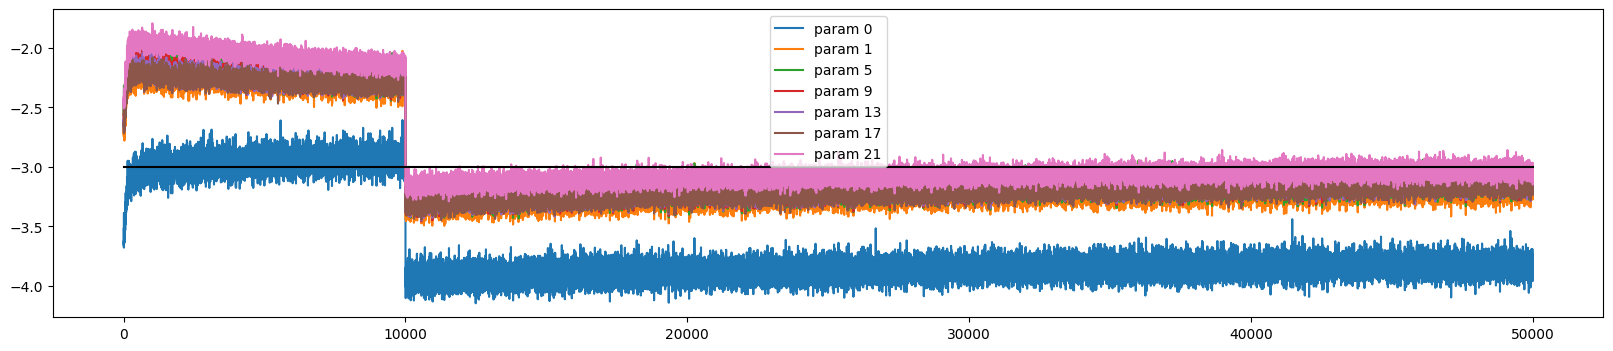

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

weight   (27, 10) | mean -0.000000 | std 1.332025e-02 | grad:data ratio 1.454851e-02
weight  (30, 100) | mean -0.000018 | std 1.541818e-02 | grad:data ratio 7.251070e-02
weight (100, 100) | mean +0.000098 | std 9.513211e-03 | grad:data ratio 7.698221e-02
weight (100, 100) | mean -0.000004 | std 8.757658e-03 | grad:data ratio 7.263832e-02
weight (100, 100) | mean -0.000104 | std 8.482622e-03 | grad:data ratio 7.167323e-02
weight (100, 100) | mean -0.000064 | std 8.126763e-03 | grad:data ratio 6.956409e-02
weight  (100, 27) | mean +0.000423 | std 1.493668e-02 | grad:data ratio 9.849571e-02


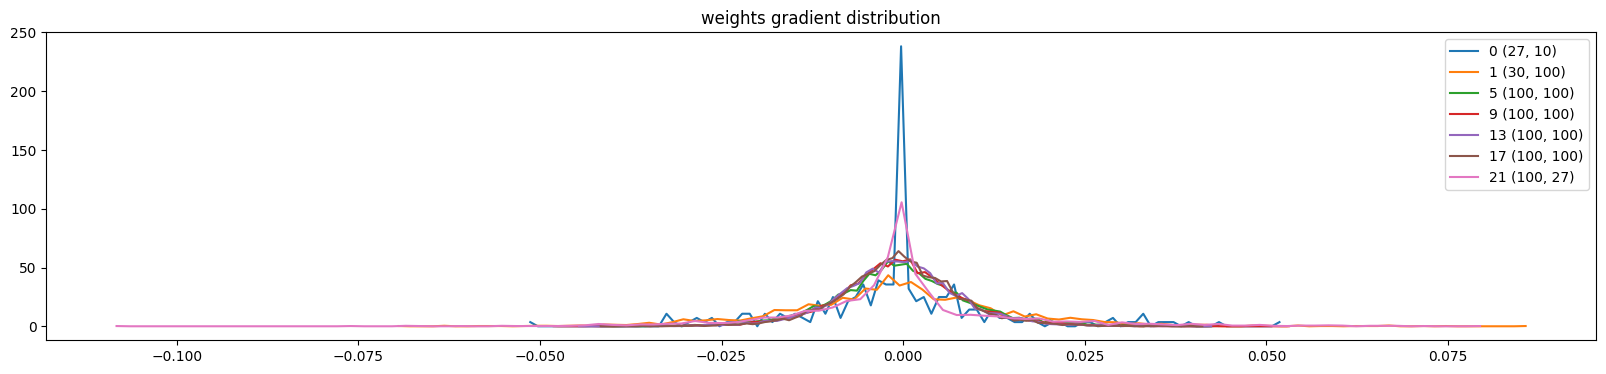

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

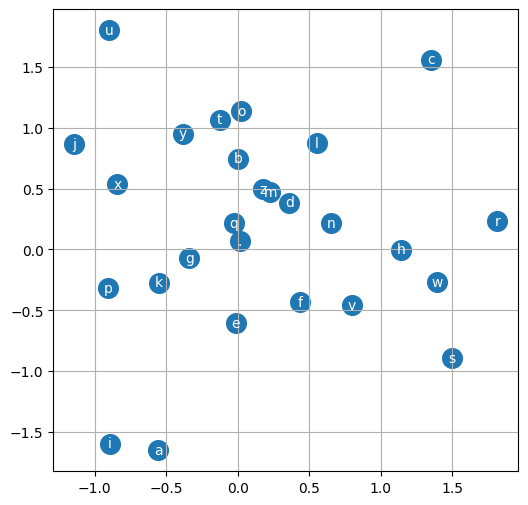

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center", color = "white")

plt.grid("minor")

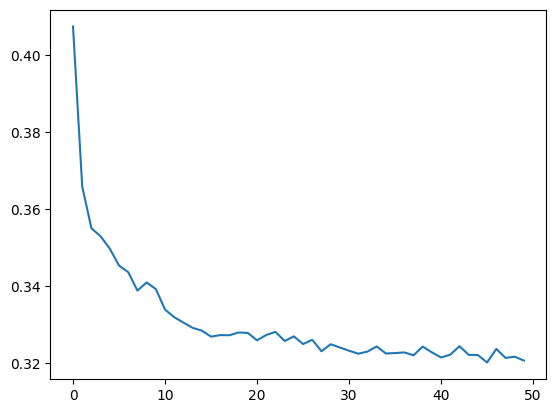

In [ ]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

# Makemore Part 4: Becoming a Backprop Ninja

In [ ]:
# utility function to compare Gradients
def cmp(s,dt,t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt,t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s | maxdiff: {maxdiff}}")

# Makemore Part 5: Building a WaveNet

In [40]:
# ---------

class Embedding():

    def __init__(self,num_embeddings,embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim), generator=g)

    def __call__(self,IX):
        self.out = self.weight[IX]
        return(self.out)

    def parameters(self):
        return [self.weight]

# ---------

class Flatten():

    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return(self.out)  

    def parameters(self):
        return([])
    
# ---------
class Sequential():

    def __init__(self,layers):
        self.layers = layers
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return(self.out)

    def parameters(self):
        return([p for layer in self.layers for p in layer.parameters()])



In [41]:
block_size = 3 # context length

def build_dataset(words: str) -> tuple[torch.Tensor, torch.Tensor]:

    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])       # 10%

In [46]:
# MLP revisted
n_embd = 10
n_hidden = 200 

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size,n_hidden),BatchNorm1D(n_hidden),Tanh(),
    Linear(           n_hidden,n_hidden),BatchNorm1D(n_hidden), Tanh(),
    Linear(          n_hidden,vocab_size)
])
# parameters init
with torch.no_grad():
    layers[-1].weight *= 0.1 # Reduce confidence last layer

parameters = model.parameters()
print(f"There is a total of {sum(p.nelement() for p in parameters)} parameters")

for p in parameters:
    p.requires_grad = True # Allow gradients to be calculated

There is a total of 52897 parameters


In [47]:
max_steps = 10000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # mini batch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits,Yb)    # cross entropy loss

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 10000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # track stats
    if i %  10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break

      0/  10000: 3.8453


In [48]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

RuntimeError: shape '[-1, 1000]' is invalid for input of size 1

In [ ]:
# put layers into eval mode
for layer in layers:
    layer.training = False

In [ ]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    